In [1]:
from math import pi as PI
import torch
from torch import nn, optim
from neurodiffeq import diff
from neurodiffeq.networks import FCNN
from neurodiffeq.temporal import generator_2dspatial_rectangle, generator_2dspatial_segment
from neurodiffeq.temporal import BoundaryCondition
from neurodiffeq.temporal import SingleNetworkApproximator2DSpatial
from neurodiffeq.temporal import Monitor2DSpatial
from neurodiffeq.temporal import _solve_2dspatial

In [2]:
def poisson_2d(u, xx, yy): 
    return diff(u, xx, order=2) + diff(u, yy, order=2) - torch.sin(PI*xx) * torch.sin(PI*yy)
def analytical_solution(xx, yy):
    return -1/(2*PI**2) * torch.sin(PI*xx) * torch.sin(PI*yy)
metrics = {}
def rmse(uu, xx, yy):
    error = uu - analytical_solution(xx, yy)
    return torch.mean(error ** 2) ** 0.5
metrics['rmse'] = rmse

dirichlet_boundary_left  = BoundaryCondition(
    form=lambda u, x, y: u,
    points_generator=generator_2dspatial_segment(size=32, start=(0.0, 0.0), end=(0.0, 1.0))
)
dirichlet_boundary_right = BoundaryCondition(
    form=lambda u, x, y: u,
    points_generator=generator_2dspatial_segment(size=32, start=(1.0, 0.0), end=(1.0, 1.0))
)
dirichlet_boundary_upper = BoundaryCondition(
    form=lambda u, x, y: u,
    points_generator=generator_2dspatial_segment(size=32, start=(0.0, 1.0), end=(1.0, 1.0))
)
dirichlet_boundary_lower = BoundaryCondition(
    form=lambda u, x, y: u,
    points_generator=generator_2dspatial_segment(size=32, start=(0.0, 0.0), end=(1.0, 0.0))
)

fcnn = FCNN(
    n_input_units=2,
    n_output_units=1,
    n_hidden_units=32,
    n_hidden_layers=1,
    actv=nn.Tanh
)
fcnn_approximator = SingleNetworkApproximator2DSpatial(
    single_network=fcnn,
    pde=poisson_2d,
    boundary_conditions=[
        dirichlet_boundary_left,
        dirichlet_boundary_right,
        dirichlet_boundary_upper,
        dirichlet_boundary_lower
    ]
)
adam = optim.Adam(fcnn_approximator.parameters(), lr=0.0005)

train_gen_spatial = generator_2dspatial_rectangle(size=(32, 32), x_min=0.0, x_max=1.0, y_min=0.0, y_max=1.0)
valid_gen_spatial = generator_2dspatial_rectangle(size=(20, 20), x_min=0.0, x_max=1.0, y_min=0.0, y_max=1.0, random=False)

<IPython.core.display.Javascript object>


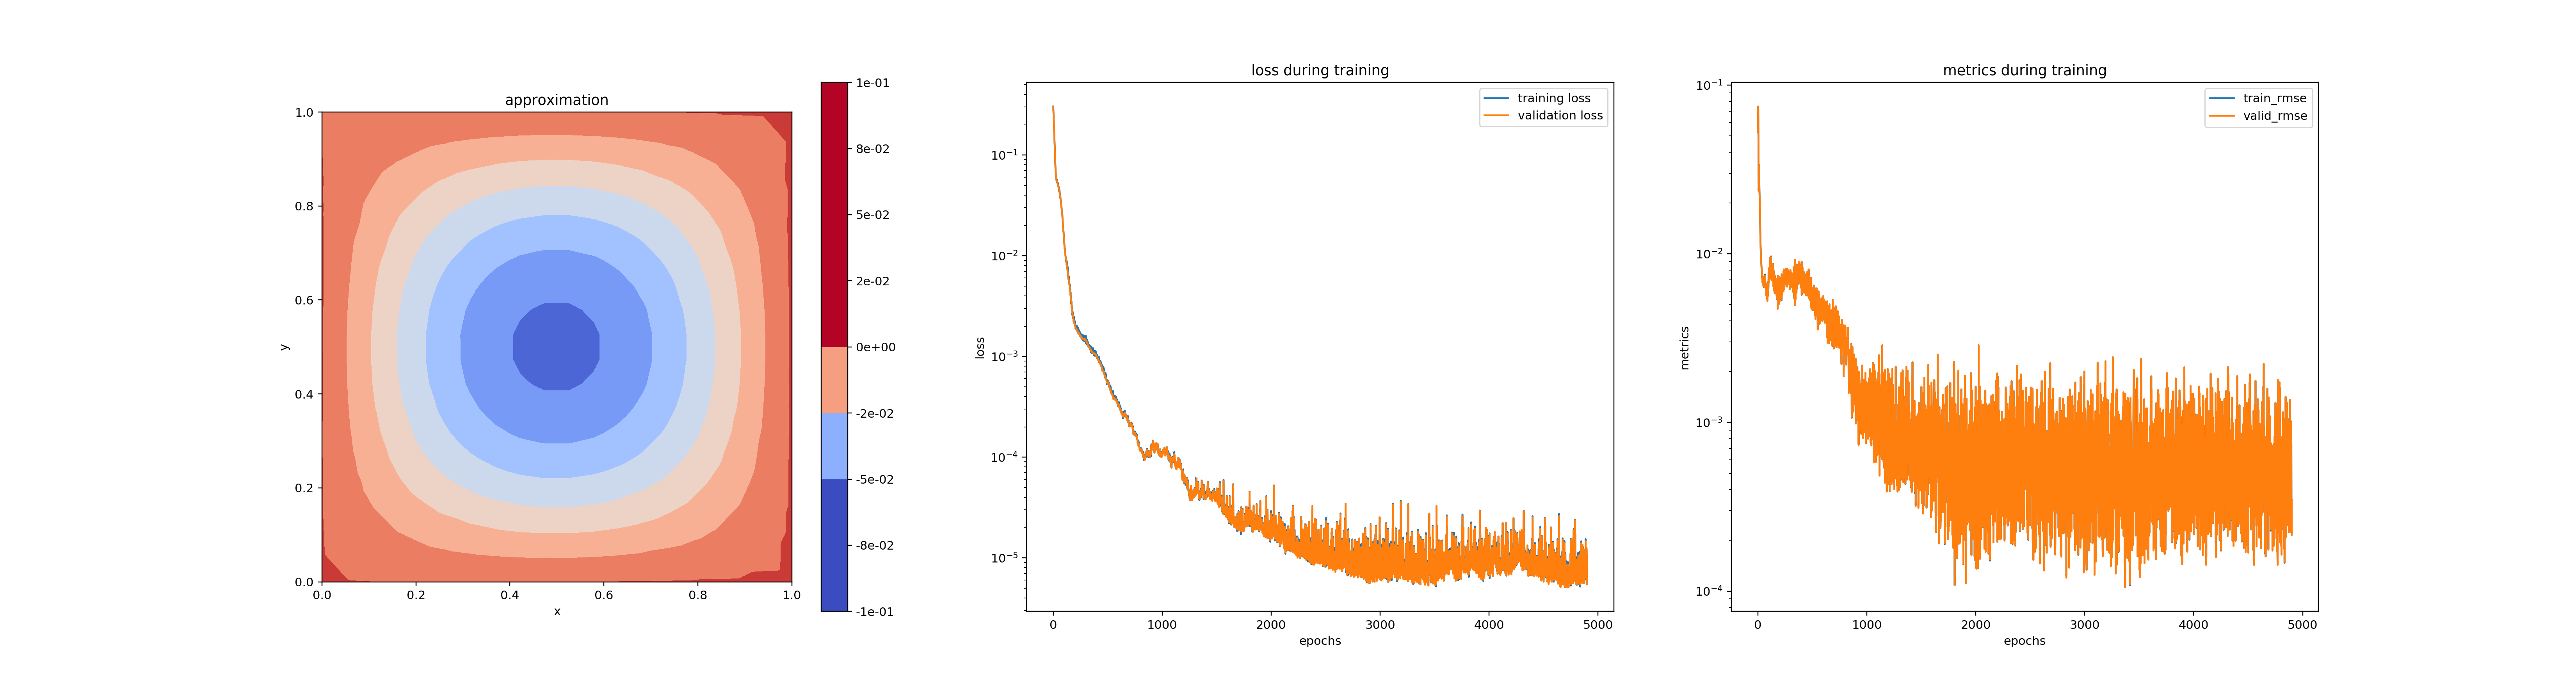

In [3]:
%matplotlib notebook
poisson_2d_solution, _ = _solve_2dspatial(
    train_generator_spatial=train_gen_spatial,
    valid_generator_spatial=valid_gen_spatial,
    approximator=fcnn_approximator,
    optimizer=adam,
    batch_size=256,
    max_epochs=5000,
    shuffle=True,
    metrics=metrics,
    monitor=Monitor2DSpatial(        
        check_on_x=torch.linspace(0.0, 1.0, 20),
        check_on_y=torch.linspace(0.0, 1.0, 20),
        check_every=100
    )
)